# COCO - Keras - Resnet34 - Lime
---
***Author: Piotr Skalski***

In [1]:
import sys
sys.path.append("../")

In [2]:
# Useful for Mac users
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
import warnings
warnings.filterwarnings('ignore')

## 0. Imports

In [4]:
import json
from typing import Dict

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

from skimage.io import imread
from keras_applications.imagenet_utils import decode_predictions
from classification_models import Classifiers
from IPython.display import display
from PIL import Image


from coco_loader import CocoLoader
from plot_utils import PlotUtil

Using TensorFlow backend.


## 1. Settings

**COMMENT:** In this experiment, we will use the [COCO][1] image data set. It contains color images with `224 x 224` resolution. All we need for our experiment is just `100` of these images. BTW, to use the COCO dataset in this experiment you must first run the `get_coco_dataset_sample.sh` script to download it.

[1]: http://cocodataset.org/#home

In [5]:
IMG_COUNT = 100
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_CHANNELS = 3
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

## 2. Auxiliary functions

In [6]:
def get_class_names() -> Dict[int, str]:
    url = "imagenet_class_index.json"
    with open(url) as f:
        return {int(k): v[1] for k, v in json.load(f).items()}

## 3. Load model

**COMMENT:** During our experiments, we will use a ready-made, trained ResNet34 model delivered in the [classification_models][1] package - Classification models Zoo - Keras (and TensorFlow Keras). 

[1]: https://github.com/qubvel/classification_models

In [7]:
ResNet34, preprocess_input = Classifiers.get('resnet34')
model = ResNet34(IMG_SHAPE, weights='imagenet')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.



In [8]:
model.summary()

Model: "resnet34"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 224, 224, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
___________________________________________________________________________________________

## 4. Load data and take a look

In [9]:
loader = CocoLoader()
data = loader.load_sample(IMG_COUNT)
data = preprocess_input(data)
data.shape

(100, 224, 224, 3)

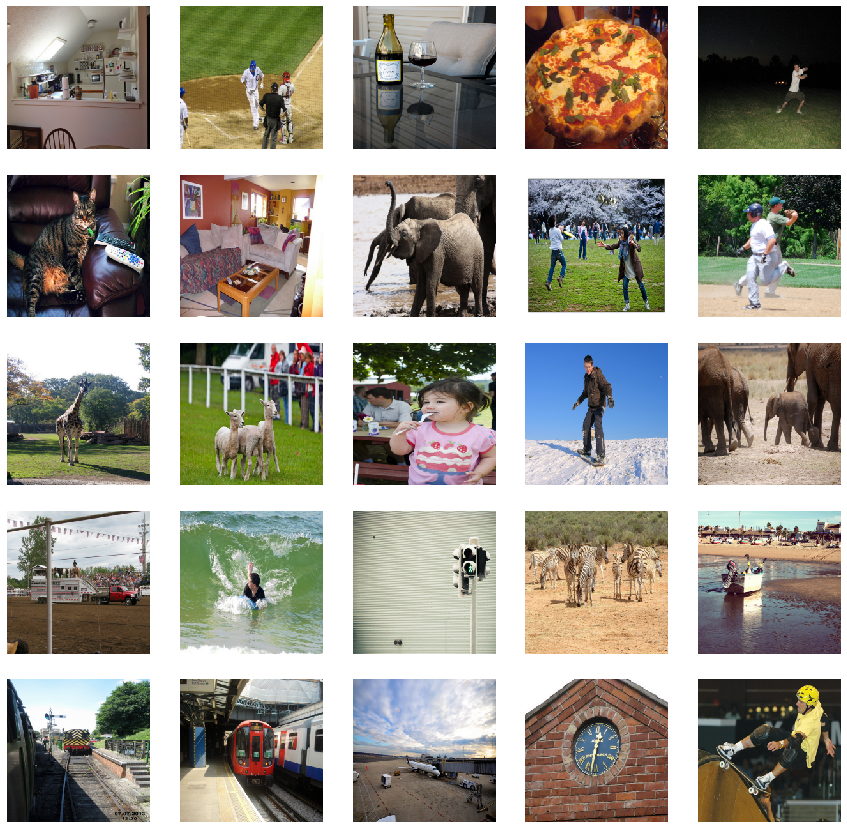

In [10]:
PlotUtil.plot_5x5_grid(data[:25], IMG_SHAPE)

## 5. Examine Test Predictions

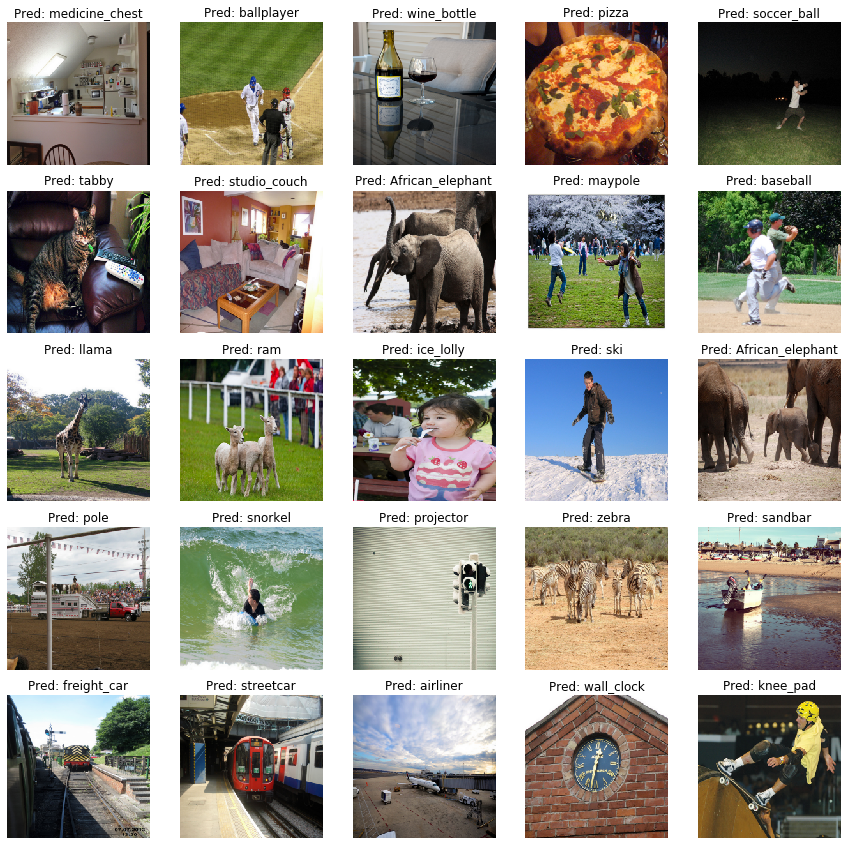

In [11]:
from keras.applications.vgg16 import decode_predictions
predictions = model.predict(data)
predictions.shape
predicted_labels = [record[0][1] for record in decode_predictions(predictions, top=1)]
PlotUtil.plot_5x5_grid(data[:25], IMG_SHAPE, cls_pred=predicted_labels[:25])

## 6. Lime Explanation

In [12]:
image_example = data[2]

### 6.1. Simple explanation

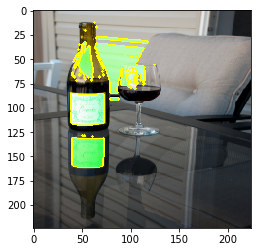

In [13]:
explainer = lime_image.LimeImageExplainer(verbose = False)
explanation = explainer.explain_instance(
    image_example, 
    classifier_fn = model.predict, 
    top_labels=100, 
    hide_color=0, 
    num_samples=1000
)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=False, 
    num_features=5, 
    hide_rest=False
)
plt.imshow(mark_boundaries(temp / 255, mask))

**COMMENT:** `Lime` offers a dedicated explainer for Image Classification models as well as a number of utilities to visualize obtained results in many different ways.

### 6.2. Advanced explanation - top N classes of objects

In [15]:
import math
from typing import Dict, Optional

import matplotlib.pyplot as plt
import numpy as np

from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries
from keras.engine.training import Model


def plot_lime_top_explanations(
    model: Model, 
    image: np.array, 
    class_names_mapping: Dict[int, str],
    top_preds_count: int = 3,
    fig_title: Optional[str] = None,
    fig_name: Optional[str] = None
) -> None:
    """
    A method that provides explanations for N top classes.
    :param model: Keras based Image Classification model
    :param image: Single image in the form of numpy array. Shape: [224, 224, 3]
    :param class_names_mapping: Dictionary that provides mapping between class inedex and name
    :param top_preds_count: Number of top predictions that we want to explain
    :param fig_title: Figure title
    :param fig_name: Output figure path
    :return:
    """
    
    image_columns = 3
    image_rows = math.ceil(top_preds_count / image_columns)
    
    explanation = explainer.explain_instance(
        image, 
        classifier_fn = model.predict, 
        top_labels=100, 
        hide_color=0, 
        num_samples=1000
    )
    
    preds = model.predict(np.expand_dims(image, axis=0))
    top_preds_indexes = np.flip(np.argsort(preds))[0,:top_preds_count]
    top_preds_values = preds.take(top_preds_indexes)
    top_preds_names = np.vectorize(lambda x: class_names[x])(top_preds_indexes)
    
    plt.style.use('dark_background')
    fig, axes = plt.subplots(image_rows, image_columns, figsize=(image_columns * 5, image_rows * 5))
    [ax.set_axis_off() for ax in axes.flat]
    
    for i, (index, value, name, ax) in \
        enumerate(zip(top_preds_indexes, top_preds_values, top_preds_names, axes.flat)):
        
        temp, mask = explanation.get_image_and_mask(
            explanation.top_labels[i], 
            positive_only=False, 
            num_features=5, 
            hide_rest=False
        )
        
        subplot_title = "{}. class: {} pred: {:.3f}".format(i + 1, name, value)
        ax.imshow(mark_boundaries(temp / 255, mask))
        ax.set_title(subplot_title, pad=20)
    
    if fig_title:
        fig.suptitle(fig_title, fontsize=30)
    if fig_name:
        plt.savefig(fig_name)
    plt.show()

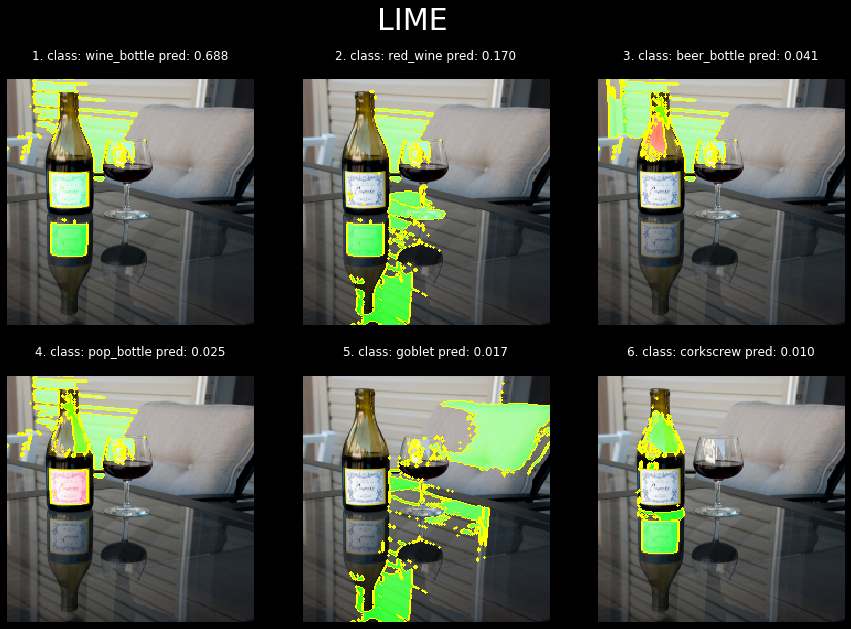

CPU times: user 4min 31s, sys: 22.9 s, total: 4min 54s
Wall time: 1min 50s


In [16]:
%%time
class_names = get_class_names()
plot_lime_top_explanations(model, image_example, class_names, top_preds_count=6, fig_title="LIME", fig_name="viz/coco_resnet34_lime.png")